In [ ]:
!pip install pytorch_lightning
!pip install Lightning
!pip install pydicom
!pip install torchmetrics
!pip install pytorch_lightning
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [28]:
from pathlib import Path
from pytorch_lightning import LightningModule, Trainer
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm
import torch.nn as nn

In [29]:
labels = pd.read_csv("train.csv")
labels.head(100)
ROOT_PATH = Path("Data/train")
SAVE_PATH = Path("Analysed")

In [30]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [31]:
train_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(1.42,3.31),
                    transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9,1.1)), 
                    transforms.RandomResizedCrop((224, 224), scale=(0.35,1))
])

val_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(1.42,3.31),
])

In [32]:
train_dataset = torchvision.datasets.DatasetFolder("Analysed/train/",loader=load_file, extensions="npy",transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("Analysed/val/",loader=load_file, extensions="npy",transform=val_transforms)

In [33]:
class CtpaAnalysis(pl.LightningModule):
    
    
    
    def __init__(self):
        
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self,batch, batch_idx):
        ctpa, label = batch
        label = label.float()
        pred = self(ctpa)[:,0]
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    def training_epoch_end(self, outs):
        self.log("Train ACC", self.train_acc.compute())
        
    def validation_step(self,batch, batch_idx):
        ctpa, label = batch
        label = label.float()
        pred = self(ctpa)[:,0]
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))
        
    
    def validation_epoch_end(self, outs):
        self.log("Val ACC", self.val_acc.compute())
        
    def configure_optimizers(self):
        return [self.optimizer]
        

In [34]:
model = CtpaAnalysis.load_from_checkpoint("logs/lightning_logs/version_9/checkpoints/epoch=34-step=57505.ckpt")

In [35]:
#model = model.load_state_dict(torch.load("logs/lightning_logs/version_1/checkpoints/epoch=34-step=57505.ckpt"), strict=False)

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
model.eval()
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): CtpaAnalysis(
    (model): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

In [38]:
preds = []
labels = []

with torch.no_grad():
    for data,label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()      

100%|████████████████████████████████████████████████████████| 81147/81147 [09:53<00:00, 136.67it/s]


In [39]:
acc = torchmetrics.Accuracy()(preds,labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)

print(f"Val Accuracy {acc}")
print(f"val Precision {precision}")
print(f"Val Recall {recall}")
print(f"Confusion Matrix {cm}")

Val Accuracy 0.9932961463928223
val Precision 0.9310415387153625
Val Recall 0.9564851522445679
Confusion Matrix tensor([[76053,   337],
        [  207,  4550]])


In [40]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [42]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(1.42,3.31),
])

In [43]:
val_dataset = torchvision.datasets.DatasetFolder("Analysed/val/",loader=load_file, extensions="npy", transform=val_transforms)

In [44]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
list(temp_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [46]:
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [47]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [144]:
class CTPAmodel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1,64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
        
    def forward(self, data):
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1,1))
        avg_output_flattened = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_output_flattened)
        return pred, feature_map

In [145]:
model = CTPAmodel.load_from_checkpoint("logs/lightning_logs/version_9/checkpoints/epoch=34-step=57505.ckpt", strict=False)

#model = nn.DataParallel(model).cuda()
model.eval();

In [146]:
def cam(model, img):
    with torch.no_grad():
        pred,  features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7,7).cpu()
    return cam_img, torch.sigmoid(pred)

In [147]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1,2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam,alpha=0.5, cmap="jet")
    plt.title(pred > 0.5)

In [166]:
img = val_dataset[-23][0]

In [167]:
val_dataset

Dataset DatasetFolder
    Number of datapoints: 81147
    Root location: Analysed/val/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=1.42, std=3.31)
           )

In [168]:
activation_map, pred= cam(model, img)

In [169]:
activation_map

tensor([[ 0.3458,  1.4835,  4.7176,  4.9516,  3.6500,  1.5000, -2.4146],
        [ 1.3475,  3.9777, 10.7194, 12.7006,  7.5201,  2.8791, -4.7615],
        [ 2.2424,  6.1003, 13.2622, 17.9915, 12.9288,  7.3827,  2.1654],
        [ 2.2336,  7.4362, 14.9969, 18.8469, 17.1230, 10.0458,  4.9935],
        [ 2.8745,  4.7173, 14.7692, 21.6954, 16.3188,  9.6333,  5.4156],
        [ 2.5892,  2.2809, 11.0234, 17.4805, 12.7655,  7.7174,  7.7953],
        [ 2.3315,  2.0353,  4.7339,  6.0814,  3.6206,  0.5710,  3.9082]])

In [170]:
pred

tensor([0.9992])

<IPython.core.display.Javascript object>


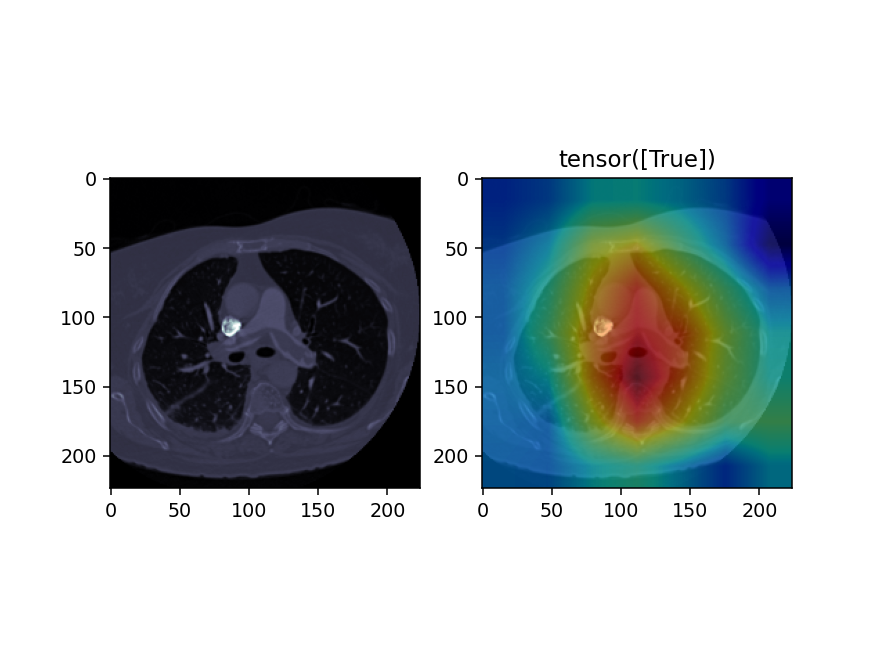

In [171]:
visualize(img,activation_map, pred)